<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/05_transfer_learning_in_tensorflow-part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow 2 : Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : fine-tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Thu Jul 15 02:04:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download some of the functions we've used previously here : https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-07-15 02:04:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-15 02:04:45 (97.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note** : If you're running this notebook in Google Colab, when it times out Colab will delete `helper functions`, so you'll have to re-download it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pre-trained models within `tf.keras.applications`  (recognizing images of food)
 link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-07-15 02:04:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   139MB/s    in 1.2s    

2021-07-15 02:04:49 (139 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many image and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
# Create training and test directory paths
train_dir ="10_food_classes_10_percent/train"
test_dir ="10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

In [8]:
# Preprocess image dataset in a directory https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

IMG_SIZE=(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1) :
  print(images, labels)

tf.Tensor(
[[[[8.25714264e+01 4.05714302e+01 1.85714283e+01]
   [8.45204086e+01 4.25204086e+01 2.05204086e+01]
   [8.25918350e+01 4.05918388e+01 1.63775501e+01]
   ...
   [7.46428986e+01 3.68571663e+01 1.80714283e+01]
   [7.01224747e+01 3.21224709e+01 1.31224718e+01]
   [7.16172714e+01 3.36172752e+01 1.46172743e+01]]

  [[8.28826523e+01 4.18826523e+01 1.98826523e+01]
   [8.21428604e+01 4.01428604e+01 1.81428566e+01]
   [8.35561218e+01 4.15561218e+01 1.73418369e+01]
   ...
   [6.90561218e+01 3.12703876e+01 1.22703876e+01]
   [6.97958832e+01 3.17958813e+01 1.27958813e+01]
   [7.08062897e+01 3.28062935e+01 1.38062916e+01]]

  [[8.74846954e+01 4.64846954e+01 2.44846935e+01]
   [7.75714264e+01 3.65714264e+01 1.45714273e+01]
   [8.19234695e+01 4.00918388e+01 1.64285717e+01]
   ...
   [7.32142868e+01 3.53826370e+01 1.63826351e+01]
   [7.06887589e+01 3.26887589e+01 1.32601862e+01]
   [7.04082413e+01 3.24082375e+01 1.29796667e+01]]

  ...

  [[3.12806854e+01 1.87092133e+01 1.31377411e+01]
   [3

## Model 0 : Building a transfer learning feature extraction model using the Keras Functional API
The sequential API is straight-forward, it runs our layers in sequential order.
But the functional API gives ur more flexibility with our models -https://www.tensorflow.org/guide/keras/functional

In [17]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model(so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3) , name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs(Not required for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model : {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D : {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks =[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model : (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D : (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210715-022722
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 305ms/step - loss: 1.8839 - accuracy: 0.4280 - val_loss: 1.3699 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - 5s 199ms/step - loss: 1.1232 - accuracy: 0.7427 - val_loss: 0.9156 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 5s 197ms/step - loss: 0.8261 - accuracy: 0.8093 - val_loss: 0.7782 - val_accuracy: 0.8141
Epoch 4/5
24/24 [==============================] - 5s 205ms/step - loss: 0.6746 - accuracy: 0.8440 - val_loss: 0.6764 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 5s 197ms/step - loss: 0.5829 - accuracy: 0.8707 - val_loss: 0.6261 - val_accuracy: 0.8289


In [18]:
# Evaulate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.6035 - accuracy: 0.8408


[0.6034579873085022, 0.8407999873161316]

In [19]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers) :
  print (layer_number, layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [20]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_2[0][0]            
_____________________________________________________________________________________

In [22]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


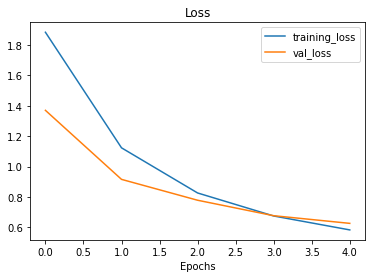

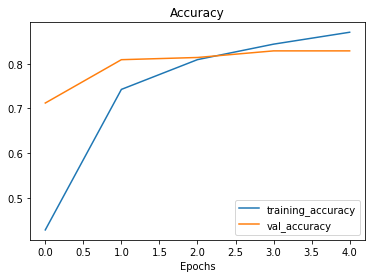

In [23]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)